# Sentiment Analyzer using machine learning models

#### Data-set: Amazon Alexa Reviews


In [1]:
#!pip install nltk
#nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')


# Import the required libraires
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

# Pre-processing library
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Models library
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv("/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv",sep="\t")
print(df.shape)
df.head()

/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv
(3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


### Check the data we are dealing with as well as some visualization

          feedback
count  3150.000000
mean      0.918413
std       0.273778
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000


array([[<AxesSubplot:title={'center':'feedback'}>]], dtype=object)

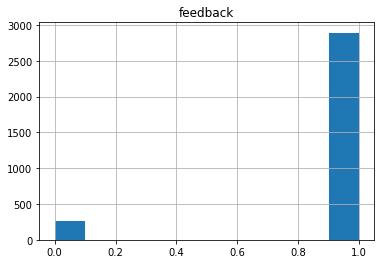

In [2]:
# Drop unrelated columns
df = df.drop(['date','variation','rating'],axis=1)
print(df.describe())
df.hist()

In [3]:
# Check for null values
df.isnull().sum()

verified_reviews    0
feedback            0
dtype: int64

### Now that we know there are no null values but there is a huge bias we will start duplicating negative feedback to balance that bias

array([[<AxesSubplot:title={'center':'feedback'}>]], dtype=object)

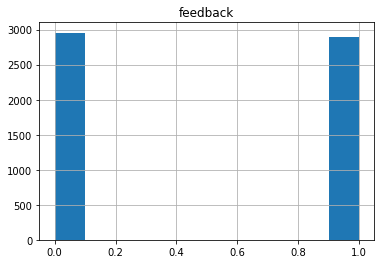

In [4]:
for i in range(3):
  df = df.append(df[ df['feedback'] == 0 ])

df = df.append(df[ df['feedback'] == 0 ].head(900))

df.hist()


### Clean and vectorize the *review* column so we can start working on it 

In [5]:
def clean_rev(review):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    stopwords.remove('not')
    stopwords.remove('nor')
    review = review.lower()
    review = re.sub("[^A-Za-z0-9]",' ',review)
    review = re.sub(r'[0-9]+',' ',review)
    review = " ".join(PorterStemmer().stem(i) for i in review.split() if i not in stopwords)
    
    return review

df['verified_reviews'] = df['verified_reviews'].apply(lambda rev: clean_rev(rev))

### Create training sets

In [6]:
x = CountVectorizer(max_features=5000).fit_transform(df['verified_reviews']).toarray()
y = df['feedback']     
x_train, x_test ,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

### Start by using SVM and creating and training model

In [7]:
model_smv = svm.SVC()
model_smv.fit(x_train, y_train)
smv_pred = model_smv.predict(x_test)

### Now the same for RandomForest model

In [8]:
model_RFC = RandomForestClassifier()
model_RFC.fit(x_train,y_train)
RFC_pred = model_RFC.predict(x_test)

### import metrics and see the performance of both models

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(f'SVM:\nConfusion matrix: \n{confusion_matrix(y_test, smv_pred)*100/len(y_test)}\n')
print(f'The F1 score is: {f1_score(y_test, smv_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, smv_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, smv_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, smv_pred)*100}\n\n\n')


print(f'RandomForest:\nConfusion matrix: \n{confusion_matrix(y_test, RFC_pred)*100/len(y_test)}\n')
print(f'The F1 score is: {f1_score(y_test, RFC_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, RFC_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, RFC_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, RFC_pred)*100}\n\n\n')

SVM:
Confusion matrix: 
[[47.60683761  0.        ]
 [ 3.5042735  48.88888889]]

The F1 score is: 96.49515041920105
The precision score is: 96.57190635451505
The recall score is: 96.6557911908646
The accuracy score is: 96.4957264957265



RandomForest:
Confusion matrix: 
[[47.60683761  0.        ]
 [ 2.05128205 50.34188034]]

The F1 score is: 97.94718234693788
The precision score is: 97.93459552495698
The recall score is: 98.04241435562805
The accuracy score is: 97.94871794871794



